In [1]:
import sys,os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import namedtuple as nt

workPath = os.getcwd()
inpPath = workPath + "/input/"
libPath = workPath + "/Libraries/"
csvPath = workPath + "/csv/"
figPath = workPath + "/figs/prim-ensemble/"
tmpPath = workPath + "/temp/prim-ensemble/"

sys.path.append(libPath)
from pyExtractDatalib import Query
from pyBuildNetworklib import Primary,Display
from pyBuildNetworklib import MeasureDistance as dist
from pyBuildNetworklib import Initialize_Primary as init
from pyBuildNetworklib import InvertMap as imap
from pyBuildNetworklib import plot_graph

#%% Get transformers and store them in csv
q_object = Query(csvPath)
gdf_home,homes = q_object.GetHomes()
roads = q_object.GetRoads()
subs = q_object.GetSubstations()
tsfr = q_object.GetTransformers()

# Read outputs of steps 1 and 2
df_hmap = pd.read_csv(csvPath+'home2link.csv')
H2Link = dict([(t.HID, (t.source, t.target)) for t in df_hmap.itertuples()])
L2Home = imap(H2Link)
links = [l for l in L2Home if 0<len(L2Home[l])<=70]
secondary_network_file = inpPath + 'secondary-network.txt'

#%% Initialize Primary Network Generation Process
graph,S2Node = init(subs,roads,tsfr,links)

print("Done")

Done


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x1c60cd64ac8>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x1c60d3fd9c8>)

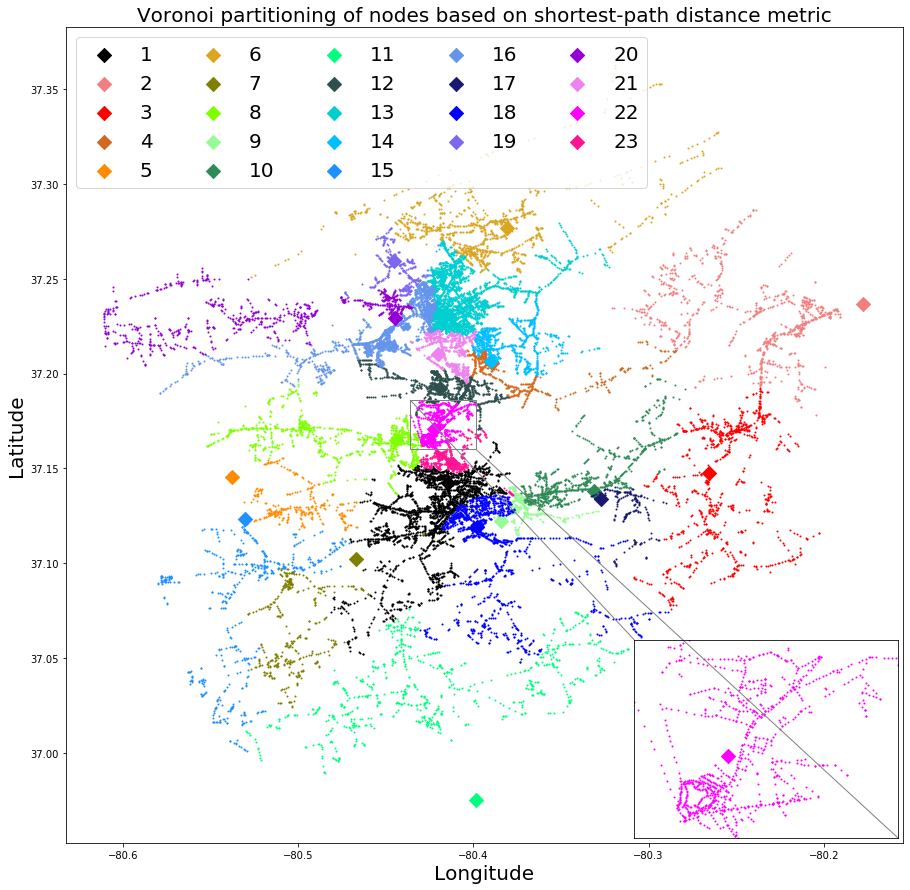

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
color_code = ['black','lightcoral','red','chocolate','darkorange','goldenrod',
              'olive','chartreuse','palegreen','seagreen','springgreen',
              'darkslategray','darkturquoise','deepskyblue','dodgerblue',
              'cornflowerblue','midnightblue','blue','mediumslateblue',
              'darkviolet','violet','magenta','deeppink','crimson','lightpink']

graph,S2Node = init(subs,roads,tsfr,links)
nodepos = nx.get_node_attributes(graph,'cord')


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
for i,s in enumerate(list(S2Node.keys())):
    ax.scatter(subs.cord[s][0],subs.cord[s][1],s=100.0,c=color_code[i],label=str(i+1),
               marker='D')
    xpts = [nodepos[r][0] for r in S2Node[s]]
    ypts = [nodepos[r][1] for r in S2Node[s]]
    ax.scatter(xpts,ypts,s=1.0,c=color_code[i])
ax.legend(loc='best',ncol=5,prop={'size': 20})
ax.set_xlabel('Longitude',fontsize=20.0)
ax.set_ylabel('Latitude',fontsize=20.0)
ax.set_title('Voronoi partitioning of nodes based on shortest-path distance metric',
             fontsize=20.0)


#%% Inset figure
axins = zoomed_inset_axes(ax, 4.0, loc=4)
i = 21
s = list(S2Node.keys())[i]
axins.scatter(subs.cord[s][0],subs.cord[s][1],s=100.0,c=color_code[i],label=str(i+1),
              marker='D')
xpts = [nodepos[r][0] for r in S2Node[s]]
ypts = [nodepos[r][1] for r in S2Node[s]]
axins.scatter(xpts,ypts,s=1.0,c=color_code[i])

axins.set_xlim(min(xpts),max(xpts))
axins.set_ylim(min(ypts),max(ypts))
axins.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


In [3]:
sub = 24664
substation = nt("local_substation",field_names=["id","cord","nodes"])
sub_data = substation(id=sub,cord=subs.cord[sub],nodes=S2Node[sub])

In [ ]:
#%% Generate primary distribution network
P = Primary(sub_data,homes,graph)
#plot_graph(P.graph,subdata=sub_data,path=figPath,filename=str(sub)+'-master')
for fmax in [250,300,350,400,450,500,550,600,650,700,750,800]:
    P.get_sub_network(secondary_network_file,flowmax=fmax,feedermax=5)
    dist_net = P.dist_net

    D = Display(dist_net)
    filename = str(sub)+'-network-f-'+str(fmax)+'-s-5'
    D.plot_network(figPath,filename)
    D.save_network(tmpPath,filename)

Setting up variables
Setting up power flow constraints
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Setting up radiality constraints
Setting up capacity constraints for road nodes
Setting up flow constraints for transformer nodes
Setting up flow constraints
Setting up connectivity constraints
Setting up constraint for number of feeders
Setting up objective function
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Heuristics unchanged
   Value: 1.0  Min: 0.0  Max: 1.0  Default: 0.05
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 6378 rows, 3441 columns and 20474 nonzeros
Model fingerprint: 0x5edc1fdd
Variable types: 1788 continuous, 1653 integer (1653 binary)
Coefficient statistics:
  Matrix range     [1e-08, 9e+02]
  Objective range  [4e-13, 8e+00]
  Bounds range     [9e-01, 1e+00]
  RHS range        [1e-01, 4e+02]
Presolve removed 1086 rows and 668 columns
Presolve time: 0.06s
Presolved: 529

 54845 21666   99.61572   72   37  100.61231   99.09451  1.51%  44.8  221s
H54870 20882                     100.6123084   99.09451  1.51%  44.8  221s
H56494 20464                     100.6123083   99.10333  1.50%  45.1  223s
 56842 20383   99.46983   74   94  100.61231   99.11145  1.49%  45.2  226s
H56844 19683                     100.6123083   99.11145  1.49%  45.2  226s
H56885 19003                     100.6123080   99.11145  1.49%  45.2  226s
 58047 20223     cutoff  158       100.61231   99.11297  1.49%  45.3  230s
H58339 19493                     100.6123079   99.12119  1.48%  45.4  230s
H58863 18719                     100.6123076   99.12287  1.48%  45.5  230s
H60351 18645                     100.6123076   99.13915  1.46%  45.7  232s
 61017 18867   99.48050   83   75  100.61231   99.15774  1.45%  45.7  235s
H61314 18226                     100.6123076   99.16123  1.44%  45.8  235s
H64091 18987                     100.6123076   99.18083  1.42%  46.0  241s
 66230 20100     cutoff  